In [1]:
!pip install openpyxl
!pip install sklearn-evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.0 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics

# models 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import ResidualsPlot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        df = pd.read_excel(path, index_col="No", sheet_name="Sheet1")

In [3]:
df.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
# strip X, Y and number values from columns 
df = df.rename(columns=lambda x: re.sub('(X|Y)\d?\s+', '', x))

# Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction date                     414 non-null    float64
 1   house age                            414 non-null    float64
 2   distance to the nearest MRT station  414 non-null    float64
 3   number of convenience stores         414 non-null    int64  
 4   latitude                             414 non-null    float64
 5   longitude                            414 non-null    float64
 6   house price of unit area             414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [6]:
# no NaN values
df.isna().any()

transaction date                       False
house age                              False
distance to the nearest MRT station    False
number of convenience stores           False
latitude                               False
longitude                              False
house price of unit area               False
dtype: bool

In [7]:
df.describe()

,transaction date,house age,distance to the nearest MRT station,number of convenience stores,latitude,longitude,house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


<AxesSubplot:xlabel='house price of unit area'>

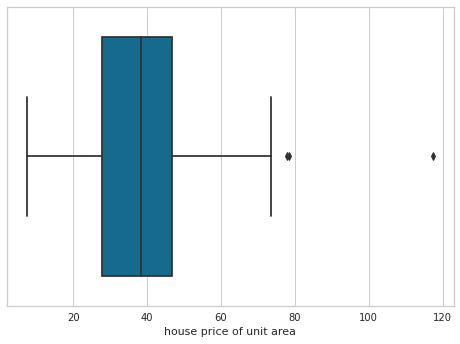

In [8]:
sea.boxplot(x='house price of unit area', data=df)
# good distribution, some outliers. may investigate further

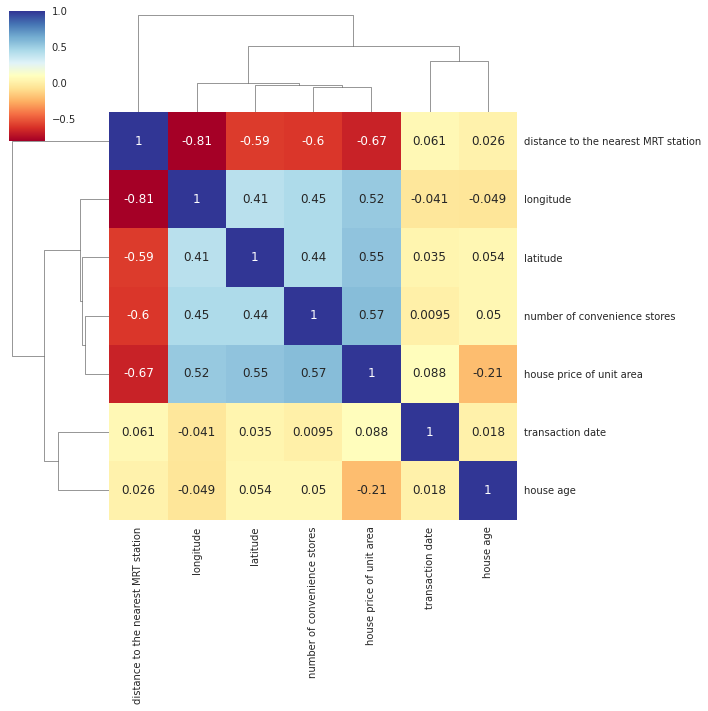

In [9]:
corr_matrix = df.corr()
sea.clustermap(corr_matrix,
            cmap='RdYlBu',
            annot=True,
            linecolor='white')

In [10]:
corr_matrix["house price of unit area"].sort_values(ascending=False)

house price of unit area               1.000000
number of convenience stores           0.571005
latitude                               0.546307
longitude                              0.523287
transaction date                       0.087529
house age                             -0.210567
distance to the nearest MRT station   -0.673613
Name: house price of unit area, dtype: float64

In [11]:
# populate list with strong correlated features
threshold = 0.5
s = corr_matrix["house price of unit area"].drop("house price of unit area")
corr_feature = s[s.abs() >= threshold].index.to_list()

In [12]:
s.abs().sort_values(ascending=False)

distance to the nearest MRT station    0.673613
number of convenience stores           0.571005
latitude                               0.546307
longitude                              0.523287
house age                              0.210567
transaction date                       0.087529
Name: house price of unit area, dtype: float64

array([[<AxesSubplot:title={'center':'distance to the nearest MRT station'}>,
        <AxesSubplot:title={'center':'number of convenience stores'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>]], dtype=object)

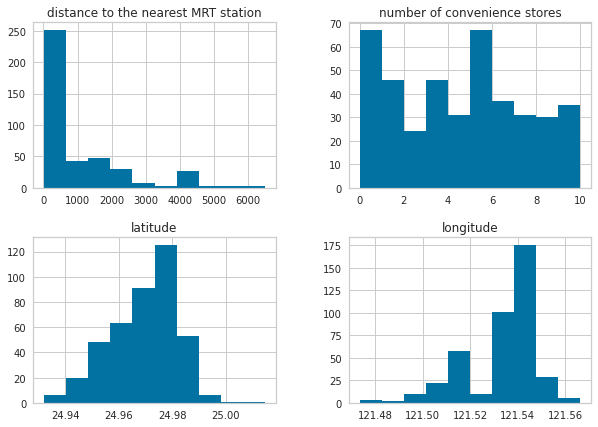

In [13]:
df[corr_feature].hist(figsize=(10,7))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

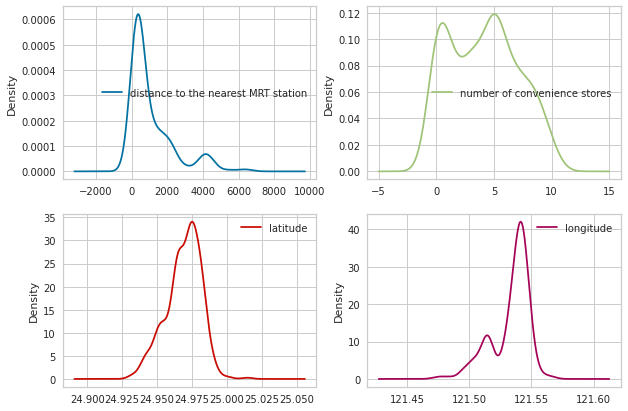

In [14]:
df[corr_feature].plot(kind='density',
                  subplots=True,
                  layout=(2, 2),
                  sharex=False,
                  figsize=(10,7))

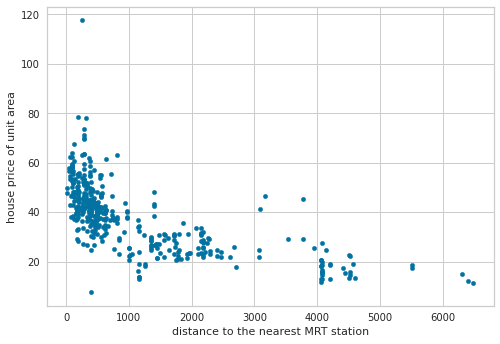

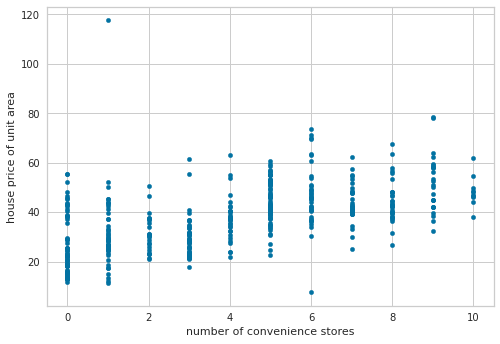

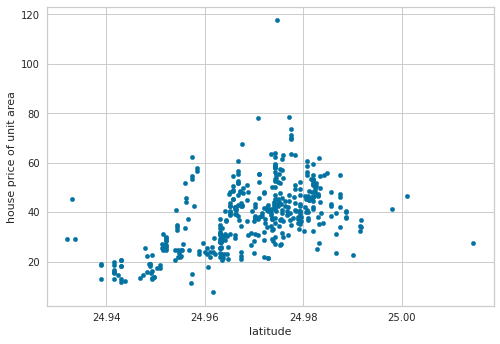

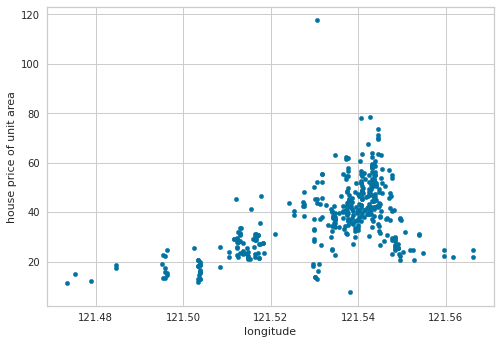

In [15]:
for corr_feat in corr_feature:
    df.plot(kind="scatter", x=corr_feat, y="house price of unit area", sharey=True, subplots=True)

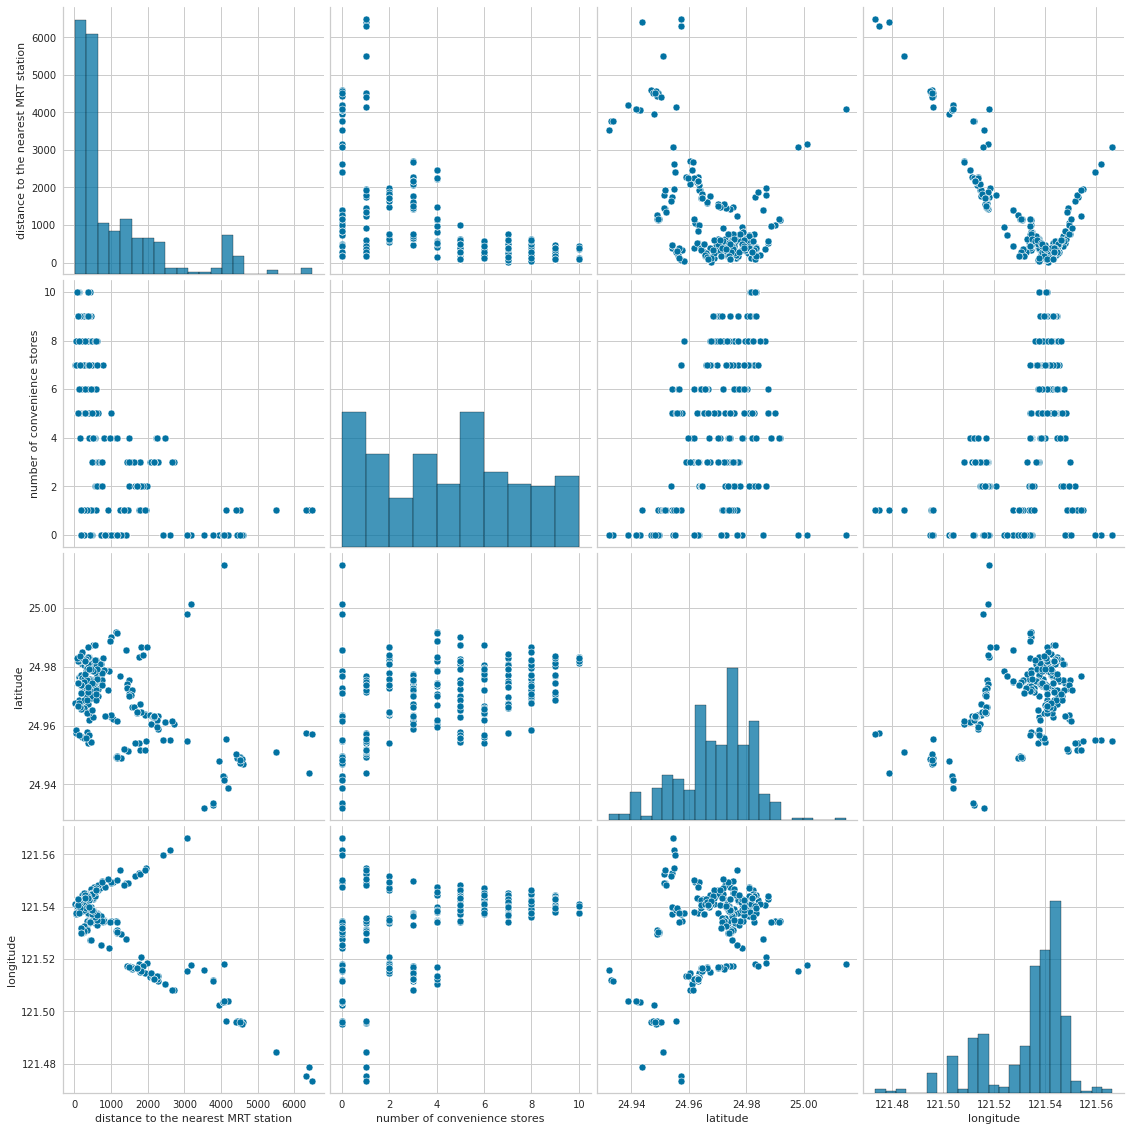

In [16]:
sea.pairplot(df, vars=corr_feature, height=4, aspect=1)

In [17]:
df[df["house price of unit area"] == df["house price of unit area"].max()]
# samples No. 271 seems to be an outlier
# distance is low but not extremely low
# convenience store number lower than mean

,transaction date,house age,distance to the nearest MRT station,number of convenience stores,latitude,longitude,house price of unit area
No,,,,,,,
271,2013.333333,10.8,252.5822,1,24.9746,121.53046,117.5


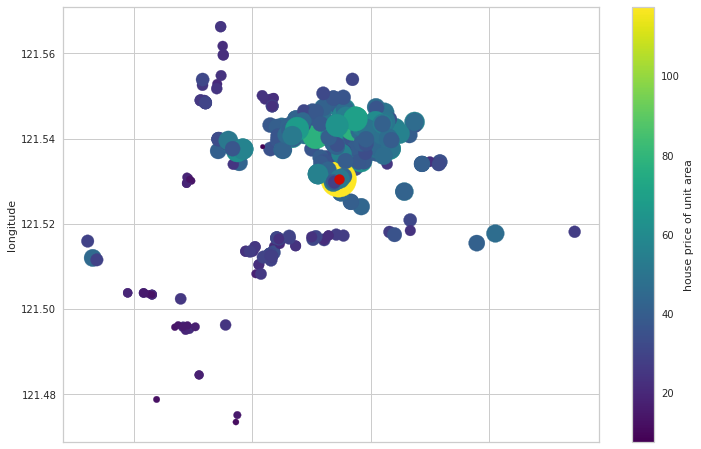

In [18]:
df.plot.scatter(x="latitude", 
                y="longitude", 
                c="house price of unit area",
                s=df["house price of unit area"]**1.5,
                colormap="viridis",
                figsize=(12,8))
plt.scatter(x=df.loc[[271]]["latitude"], 
            y=df.loc[[271]]["longitude"],
            c="r",
            s=100)
# looks like the most priced house is right in the most expensive area, therefore i do not classify this as an outlier

# Pre-processing

In [19]:
# constant randomization for better consistency
np.random.seed(17)

In [20]:
# shuffle the data for ii distribution
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
# split into traning and testing
X = df[corr_feature].values
y = df["house price of unit area"].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

In [23]:
X_train.shape, X_test.shape

((331, 4), (83, 4))

In [24]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Selection

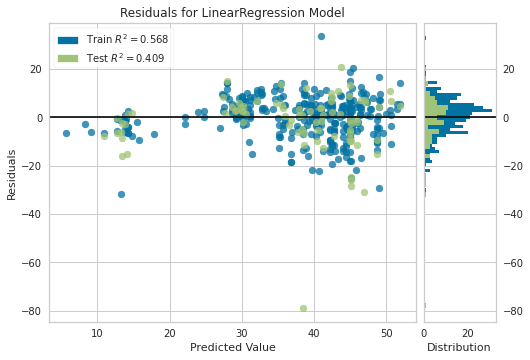

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [25]:
lr = LinearRegression()
residualPlot = ResidualsPlot(lr)

residualPlot.fit(X_train, y_train)
residualPlot.score(X_test, y_test)
residualPlot.show()

# there seems to be some linearity

In [26]:
# we are going to evaluate some models 
# to choose the best performing one and
# hyperparameter tuning it

models = [
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    SVR()
]
models_name = [
    "Linear Regression",
    "K-Neighbors Regressor",
    "Decision Tree Regressor",
    "SVR"
]

In [27]:
raw_results = {}

In [28]:
def evaluate_model(X, y, model, name, metric, folds):
    # perform k-fold cross validation
    scores = cross_val_score(estimator=model, 
                             X=X, 
                             y=y, 
                             scoring=metric, 
                             cv=folds)
    raw_results[name] = scores
    return scores

In [29]:
def print_model_results(name, scores):
    print(f"{name} best scored --> {max(scores)}")
    print(f"{name} average scored --> %.5f +- %.5f\n" % (scores.mean(), scores.std()))

In [30]:
print("R2 Metrics Comparison: \n")
for model, name in zip(models, models_name):
    scores = evaluate_model(X_train, y_train, model, name, 'r2', 10)
    print_model_results(name, scores)

R2 Metrics Comparison: 

Linear Regression best scored --> 0.6676373265379953
Linear Regression average scored --> 0.53771 +- 0.10838

K-Neighbors Regressor best scored --> 0.805588320182387
K-Neighbors Regressor average scored --> 0.66364 +- 0.08995

Decision Tree Regressor best scored --> 0.8087214086724778
Decision Tree Regressor average scored --> 0.58528 +- 0.13938

SVR best scored --> 0.6398866592643817
SVR average scored --> 0.54346 +- 0.05638



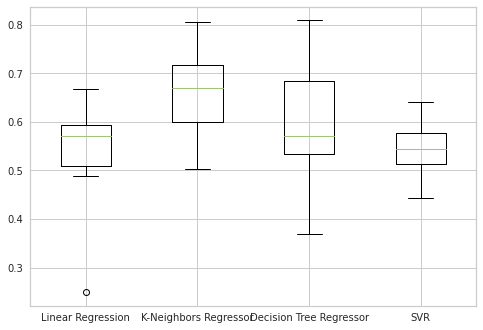

In [31]:
plt.boxplot([raw_results[i] for i in raw_results], labels=raw_results.keys())
plt.show()

In [32]:
for model, name in zip(models, models_name):
    scores = evaluate_model(X_train, y_train, model, name, 'neg_root_mean_squared_error', 10)
    print_model_results(name, scores)

Linear Regression best scored --> -6.522218301505434
Linear Regression average scored --> -8.36062 +- 1.06501

K-Neighbors Regressor best scored --> -5.3561078134304685
K-Neighbors Regressor average scored --> -7.10076 +- 1.06543

Decision Tree Regressor best scored --> -5.478719968920034
Decision Tree Regressor average scored --> -7.74755 +- 1.23484

SVR best scored --> -7.03883765362415
SVR average scored --> -8.38052 +- 1.15171



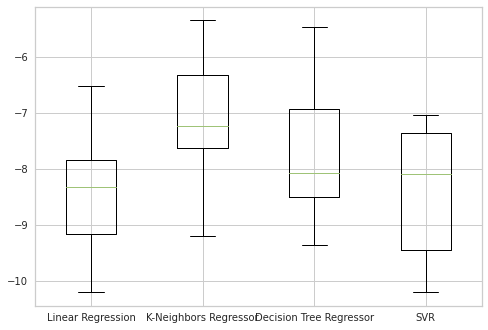

In [33]:
plt.boxplot([raw_results[i] for i in raw_results], labels=raw_results.keys())
plt.show()

# Hyperparameter Tuning

In [34]:
# selecting the best performing estimator
knn = KNeighborsRegressor()

In [35]:
name = "K-Neighbors Regressor"

In [36]:
tuned_results = {}
best_params = []

In [37]:
# wide range parameters
h_param = {
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'n_neighbors': list(range(1, 30, 1)), 
        'weights': ['uniform', 'distance'], 
    }

In [38]:
def print_model_results(name, scores, split_scores):
    print(f"{name} results:\n")
    print("best test score in a fold --> %.5f +- %.5f" % (scores.best_score_, split_scores.std()))
    print(f"best params --> {scores.best_params_}")
    print(f"metric used: {scores.scorer_}\n")
        
    improv = np.abs(scores.best_score_ - raw_results[name].mean())
    
    print("tuned performed %.3f better of raw" % (improv))

In [39]:
# grid search validation
cv = GridSearchCV(estimator=knn, 
                  param_grid=h_param, 
                  cv=10, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True, refit=True, verbose=1,
                  n_jobs=-1)
cv.fit(X_train, y_train)

Fitting 10 folds for each of 232 candidates, totalling 2320 fits


GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [40]:
# convert to df for better parsing
res = pd.DataFrame(cv.cv_results_)

In [41]:
# retrieve best ranking split scores
sorted_res = res.sort_values(by=['rank_test_score'])
sorted_res[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
split_scores = list()
for i in range(10):
    split_scores.append(sorted_res.loc[[197]]['split%d_test_score' % i].values[0])
split_scores = np.asarray(split_scores)

In [42]:
print_model_results(name, cv, split_scores)

K-Neighbors Regressor results:

best test score in a fold --> -6.82177 +- 1.28480
best params --> {'algorithm': 'brute', 'n_neighbors': 13, 'weights': 'distance'}
metric used: make_scorer(mean_squared_error, greater_is_better=False, squared=False)

tuned performed 0.279 better of raw


Text(0.5, 1.0, 'RMSE Comparison between Tuned and raw')

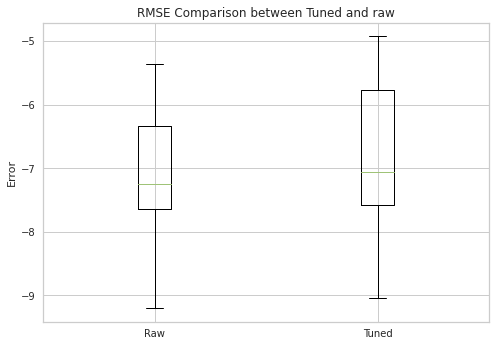

In [43]:
plt.boxplot([raw_results[name], split_scores], labels=['Raw', 'Tuned'])
plt.ylabel("Error")
plt.title("RMSE Comparison between Tuned and raw")

In [44]:
print(raw_results[name].std(), split_scores.std())

1.0654302215881968 1.2848023677604443


Text(0, 0.5, 'NRMSE')

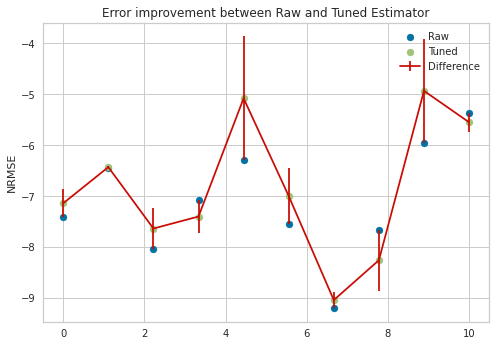

In [45]:
plt.scatter(np.linspace(0, 10, 10), raw_results[name])
plt.scatter(np.linspace(0, 10, 10), split_scores)
plt.errorbar(np.linspace(0, 10, 10), split_scores, raw_results[name] - split_scores, c='r')
plt.legend(['Raw', 'Tuned', 'Difference'])
plt.title('Error improvement between Raw and Tuned Estimator')
plt.ylabel('NRMSE')

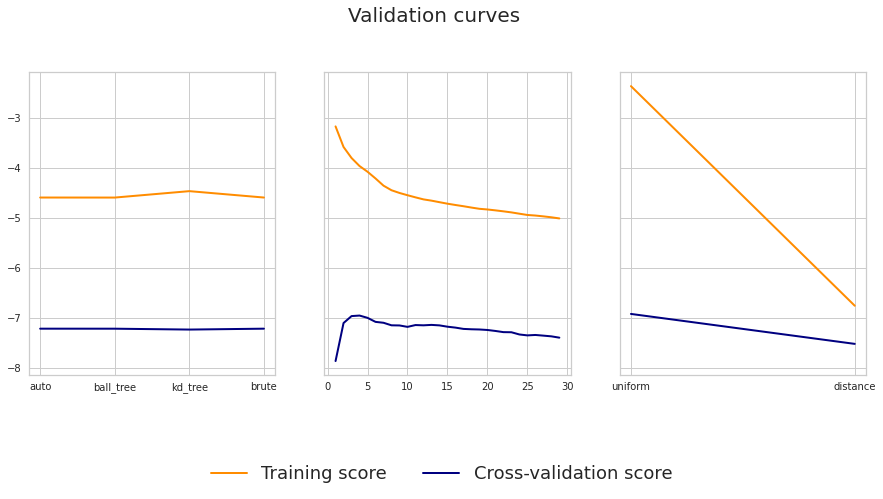

In [46]:
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score',
           'std_train_score']


def pooled_var(stds):
    n = 5
    return np.sqrt(sum((n - 1) * (stds ** 2)) / len(stds) * (n - 1))


fig, axes = plt.subplots(1, len(h_param),
                         figsize=(5 * len(h_param), 7),
                         sharey='row',
                         squeeze=True)

for idx, (param_name, param_range) in enumerate(h_param.items()):
    grouped_df = res.groupby(f'param_{param_name}')[results] \
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = res.groupby(f'param_{param_name}')[results]
    lw = 2
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                   color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                   color="navy", lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=20)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=18)

fig.subplots_adjust(bottom=0.25, top=0.85)
plt.show()

# plain overfitting with k=1

# Testing

In [47]:
y_pred = cv.predict(X_test)

In [48]:
def get_rmse(y_test, y_pred):
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [49]:
def get_mae(y_test, y_pred):
    return metrics.mean_absolute_error(y_test, y_pred)

In [50]:
def print_metrics(y_test, y_pred):
    print('RMSE -->', get_rmse(y_test, y_pred))
    print('MAE -->', get_mae(y_test, y_pred))
    print('R2 -->', metrics.r2_score(y_test, y_pred))

In [51]:
print_metrics(y_test, y_pred)

RMSE --> 10.83980728412102
MAE --> 5.756328941076993
R2 --> 0.5797087241139347


In [52]:
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [53]:
y_pred_raw = knn.predict(X_test)

In [54]:
print_metrics(y_test, y_pred_raw)

RMSE --> 11.40765141663145
MAE --> 6.307228915662651
R2 --> 0.5345213812030253


Text(0.5, 1.0, 'RMSE Comparison Tuned vs Raw')

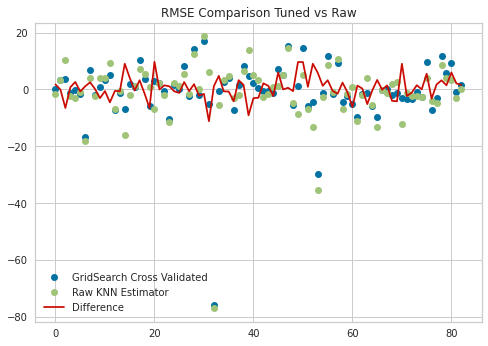

In [55]:
plt.plot(y_pred - y_test, marker='o', linestyle='')
plt.plot(y_pred_raw - y_test, marker='o', linestyle='')
plt.plot((y_pred - y_test) - (y_pred_raw - y_test))

plt.legend(['GridSearch Cross Validated', 'Raw KNN Estimator', 'Difference'])
plt.title("RMSE Comparison Tuned vs Raw")

In [56]:
((y_pred - y_test) - (y_pred_raw - y_test)).mean()

0.5615520099244472

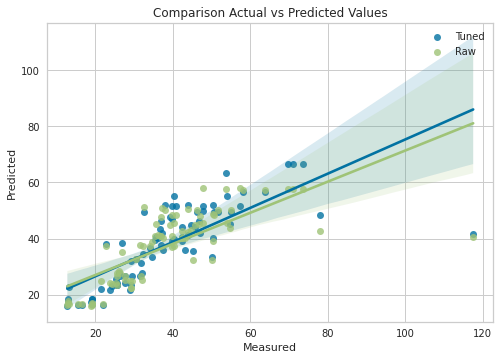

In [57]:
sea.regplot(x=y_test, y=y_pred, label='Tuned')
sea.regplot(x=y_test, y=y_pred_raw, label='Raw')
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title("Comparison Actual vs Predicted Values")
plt.legend()

(0.0, 80.0)

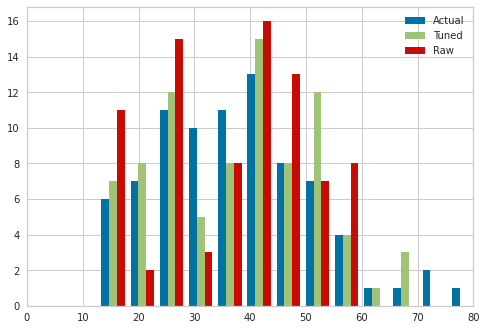

In [58]:
plt.hist([y_test, y_pred, y_pred_raw], alpha=1, bins=20)
plt.legend(['Actual', 'Tuned', 'Raw'])
plt.xlim(0,80)

# resized because of outlier

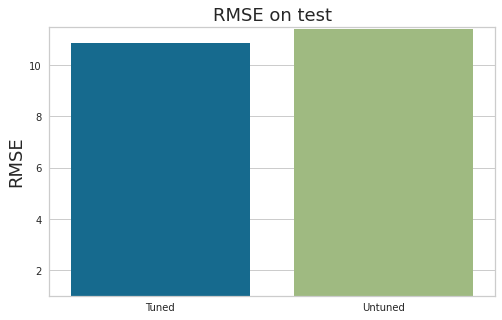

In [59]:
sea.barplot(x=["Tuned","Untuned"], y=[
    get_rmse(y_test, y_pred),
    get_rmse(y_test, y_pred_raw)])
plt.ylabel('RMSE', size=18)
plt.title('RMSE on test', fontsize=18)
plt.subplots_adjust(bottom=0.2)
plt.ylim(1,11.5)
plt.show()

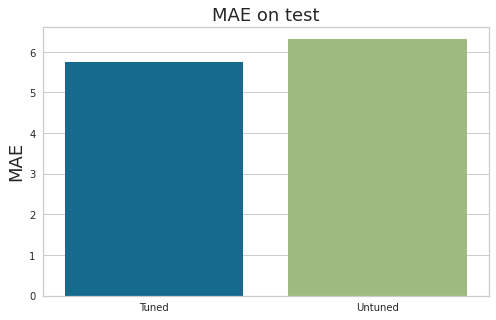

In [60]:
sea.barplot(x=["Tuned","Untuned"], y=[
    get_mae(y_test, y_pred),
    get_mae(y_test, y_pred_raw)])
plt.ylabel('MAE', size=18)
plt.title('MAE on test', fontsize=18)
plt.subplots_adjust(bottom=0.2)
plt.show()

In [61]:
knn.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}